In [79]:
import fsspec
import pandas as pd
from plotnine import (
    ggplot,
    geom_point,
    aes,
    stat_smooth,
    facet_wrap,
    scale_x_log10,
    geom_histogram,
    labels,
    labs,
)
import janitor

In [54]:
fs = fsspec.filesystem("filecache", target_protocol="https", cache_storage="/tmp/files")
fs

In [55]:
df = pd.read_csv(
    fs.open(
        'https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2021/2021-05-18/survey.csv'
    ),
    parse_dates=['timestamp'],
)
df.head()

,timestamp,how_old_are_you,industry,job_title,additional_context_on_job_title,annual_salary,other_monetary_comp,currency,currency_other,additional_context_on_income,country,state,city,overall_years_of_professional_experience,years_of_experience_in_field,highest_level_of_education_completed,gender,race
0,2021-04-27 11:02:10,25-34,Education (Higher Education),Research and Instruction Librarian,NaN,55000,0.0,USD,NaN,NaN,United States,Massachusetts,Boston,5-7 years,5-7 years,Master's degree,Woman,White
1,2021-04-27 11:02:22,25-34,Computing or Tech,Change & Internal Communications Manager,NaN,54600,4000.0,GBP,NaN,NaN,United Kingdom,NaN,Cambridge,8 - 10 years,5-7 years,College degree,Non-binary,White
2,2021-04-27 11:02:38,25-34,"Accounting, Banking & Finance",Marketing Specialist,NaN,34000,NaN,USD,NaN,NaN,US,Tennessee,Chattanooga,2 - 4 years,2 - 4 years,College degree,Woman,White
3,2021-04-27 11:02:41,25-34,Nonprofits,Program Manager,NaN,62000,3000.0,USD,NaN,NaN,USA,Wisconsin,Milwaukee,8 - 10 years,5-7 years,College degree,Woman,White
4,2021-04-27 11:02:42,25-34,"Accounting, Banking & Finance",Accounting Manager,NaN,60000,7000.0,USD,NaN,NaN,US,South Carolina,Greenville,8 - 10 years,5-7 years,College degree,Woman,White


In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26232 entries, 0 to 26231
Data columns (total 18 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   timestamp                                 26232 non-null  datetime64[ns]
 1   how_old_are_you                           26232 non-null  object        
 2   industry                                  26173 non-null  object        
 3   job_title                                 26232 non-null  object        
 4   additional_context_on_job_title           6763 non-null   object        
 5   annual_salary                             26232 non-null  int64         
 6   other_monetary_comp                       19447 non-null  float64       
 7   currency                                  26232 non-null  object        
 8   currency_other                            166 non-null    object        
 9   additional_context_on_income

In [97]:
df.describe()

,annual_salary,other_monetary_comp
count,2.623200e+04,1.944700e+04
mean,1.457254e+05,1.848935e+04
std,5.543526e+06,8.616672e+05
min,0.000000e+00,0.000000e+00
25%,5.400000e+04,0.000000e+00
50%,7.600000e+04,2.000000e+03
75%,1.100000e+05,1.000000e+04
max,8.700000e+08,1.200000e+08


In [56]:
df.how_old_are_you.value_counts()

25-34         11748
35-44          9398
45-54          3042
18-24          1015
55-64           931
65 or over       88
under 18         10
Name: how_old_are_you, dtype: int64

In [57]:
df.job_title.value_counts()

Software Engineer                       289
Project Manager                         242
Director                                211
Senior Software Engineer                200
Executive Assistant                     171
                                       ... 
Events and Outreach Manager               1
Head of Circulation and Reference         1
Grant Advisor                             1
Coordinator, Marketing and Promotion      1
Knowledge Management Manager              1
Name: job_title, Length: 12622, dtype: int64

In [58]:
df.currency.value_counts()

USD        21852
CAD         1564
GBP         1521
EUR          585
AUD/NZD      469
Other        133
CHF           35
SEK           34
JPY           22
ZAR           13
HKD            4
Name: currency, dtype: int64

In [ ]:
df.rem

In [91]:
data_usd = (df
        .filter_on("currency == 'USD'")
        .filter_on("annual_salary >= 5000")
        .filter_on("annual_salary <= 2e6")
        .
       )
data_usd.head()

,timestamp,how_old_are_you,industry,job_title,additional_context_on_job_title,annual_salary,other_monetary_comp,currency,currency_other,additional_context_on_income,country,state,city,overall_years_of_professional_experience,years_of_experience_in_field,highest_level_of_education_completed,gender,race
0,2021-04-27 11:02:10,25-34,Education (Higher Education),Research and Instruction Librarian,NaN,55000,0.0,USD,NaN,NaN,United States,Massachusetts,Boston,5-7 years,5-7 years,Master's degree,Woman,White
2,2021-04-27 11:02:38,25-34,"Accounting, Banking & Finance",Marketing Specialist,NaN,34000,NaN,USD,NaN,NaN,US,Tennessee,Chattanooga,2 - 4 years,2 - 4 years,College degree,Woman,White
3,2021-04-27 11:02:41,25-34,Nonprofits,Program Manager,NaN,62000,3000.0,USD,NaN,NaN,USA,Wisconsin,Milwaukee,8 - 10 years,5-7 years,College degree,Woman,White
4,2021-04-27 11:02:42,25-34,"Accounting, Banking & Finance",Accounting Manager,NaN,60000,7000.0,USD,NaN,NaN,US,South Carolina,Greenville,8 - 10 years,5-7 years,College degree,Woman,White
5,2021-04-27 11:02:46,25-34,Education (Higher Education),Scholarly Publishing Librarian,NaN,62000,NaN,USD,NaN,NaN,USA,New Hampshire,Hanover,8 - 10 years,2 - 4 years,Master's degree,Man,White


/home/andersy005/mambaforge/envs/cu/lib/python3.10/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 123'. Pick better value with 'binwidth'.


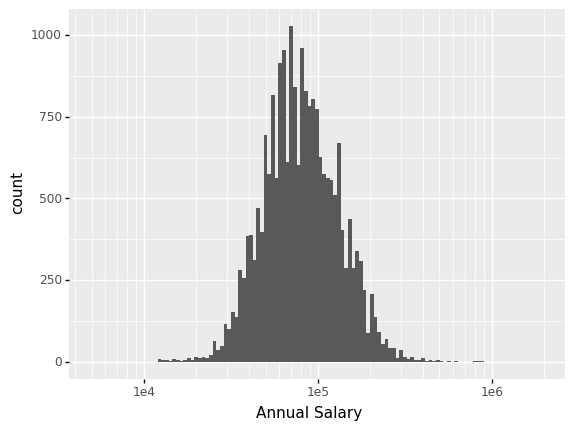

<ggplot: (8776320920051)>

In [94]:
(
    ggplot(data_usd, aes('annual_salary'))
    + geom_histogram()
    + scale_x_log10()
    + labs(x="Annual Salary")
)

In [95]:
data_usd.state.value_counts()

California                 2423
New York                   2036
Massachusetts              1453
Texas                      1168
Illinois                   1125
                           ... 
Nevada, Oregon                1
New Jersey, Virginia          1
Montana, Wyoming              1
Colorado, Massachusetts       1
Oregon, Washington            1
Name: state, Length: 124, dtype: int64

In [45]:
mtcars

,name,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
3,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
4,Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2
5,Valiant,18.1,6,225.0,105,2.76,3.460,20.22,1,0,3,1
6,Duster 360,14.3,8,360.0,245,3.21,3.570,15.84,0,0,3,4
7,Merc 240D,24.4,4,146.7,62,3.69,3.190,20.00,1,0,4,2
8,Merc 230,22.8,4,140.8,95,3.92,3.150,22.90,1,0,4,2
9,Merc 280,19.2,6,167.6,123,3.92,3.440,18.30,1,0,4,4
